In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras import Sequential, Input, layers
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import LabelEncoder

2025-09-02 16:10:42.603098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Import the dataset

In [3]:
file_path="data_sampling200_topstyles.csv"
df = pd.read_csv(file_path)
df.head()

,artist,style,movement,tags,url,img,file_name,genre_list,Artwork,Date
0,Eleanor Fortescue-Brickdale,Romanticism,Romanticism,"['Middleages', 'Prophet']",https://www.wikiart.org/en/eleanor-fortescue-b...,https://uploads0.wikiart.org/00289/images/elea...,52663-efb-1910-p127-elizabeth-prayed-to-god-to...,['illustration'],NaN,NaN
1,Pierre-Paul Prud'hon,Romanticism,Neoclassicism,"['female-portraits', 'mother-and-child', 'Lady']",https://www.wikiart.org/en/pierre-paul-prud-ho...,https://uploads8.wikiart.org/images/pierre-pau...,31660-untitled.jpg,['portrait'],Untitled,XVIII-XIX cent.
2,Sorin Dumitrescu,Surrealism,Neo-Orthodoxism,['Table'],https://www.wikiart.org/en/sorin-dumitrescu/il...,https://uploads7.wikiart.org/images/sorin-dumi...,243190-illustration-for-nichita-stanescu-s-kno...,['illustration'],Illustration for Nichita Stanescu's Knots and ...,1982
3,Edouard Cortes,Post-Impressionism,Post-Impressionism,"['streets-and-squares', 'houses-and-buildings'...",https://www.wikiart.org/en/edouard-cortes/tuil...,https://uploads4.wikiart.org/images/edouard-co...,124633-tuileries-garden-1.jpg,['cityscape'],NaN,NaN
4,Eugene Delacroix,Romanticism,Romanticism,"['famous-people', 'Louis-de-Bourbon', 'Bishop-...",https://www.wikiart.org/en/eugene-delacroix/th...,https://uploads0.wikiart.org/images/eugene-del...,39529-the-assassination-of-the-bishop-of-liege...,['history painting'],NaN,NaN


In [4]:
list_styles = df['style'].unique().tolist()
list_styles

['Romanticism',
 'Surrealism',
 'Post-Impressionism',
 'Impressionism',
 'Realism',
 'Expressionism',
 'Abstract Expressionism',
 'Cubism',
 'Symbolism',
 'Neoclassicism']

In [5]:
nb_styles = len(list_styles)
nb_styles

10

# Image checking

In [6]:
img_nm=0

In [7]:
from PIL import Image
import os

# Chemin vers le dossier contenant l'image
image_dir = "../raw_data/sample200"
files = os.listdir(image_dir)

# Test avec le premier fichier de la liste
image_name = files[img_nm]
image_path = os.path.join(image_dir, image_name)
print(image_path)

from PIL import Image
img = Image.open(image_path)

../raw_data/sample/fortuny-la-senyoreta-del-castillo-en-el-seu-llit-de-mort.jpg


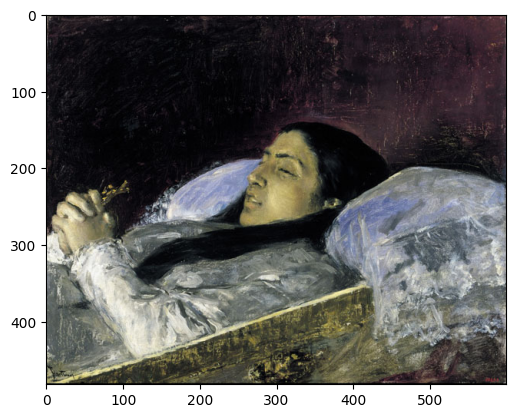

In [8]:
plt.imshow(img)

In [9]:
img_array = np.array(img) 
img_array.shape

(482, 600, 3)

# Image resizing

In [10]:
from PIL import Image

# Redimensionner à 128x128
img_resized = img.resize((128, 128), Image.BICUBIC)

# Convertir en array si besoin
import numpy as np
img_array_resized = np.array(img_resized)
print(img_array_resized.shape)

(128, 128, 3)


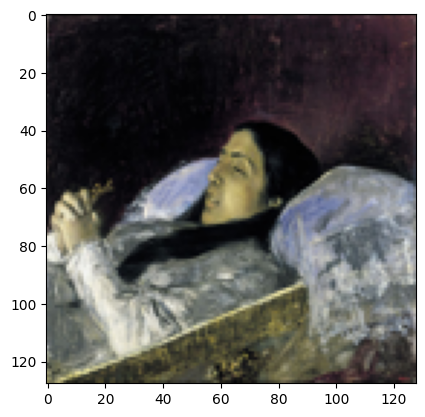

In [11]:
plt.imshow(img_resized)

In [12]:
def load_and_resize_images(image_dir):
    """
    Charge toutes les images d'un dossier, les redimensionne en conservant le ratio
    avec padding noir et les retourne sous forme de tableau NumPy.
    
    Args:
        image_dir (str): Chemin vers le dossier contenant les images.
        target_size (tuple): Taille finale des images (largeur, hauteur).
        
    Returns:
        np.ndarray: Tableau de forme (n_images, hauteur, largeur, canaux)
    """
    images_list = []
    
    for filename in os.listdir(image_dir):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp')):
            img_path = os.path.join(image_dir, filename)
            img = Image.open(img_path).convert('RGB') 

            img_resized = img.resize((128, 128), Image.BICUBIC)
            
            # convert into an array and add to list 
            img_array = np.array(img_resized)
            images_list.append(img_array)
    
    # Convertir la liste en tableau NumPy
    images_np = np.stack(images_list)
    return images_np

In [13]:
image_dir = "../raw_data/sample200"
images_np = load_and_resize_images(image_dir)

Test on images : 

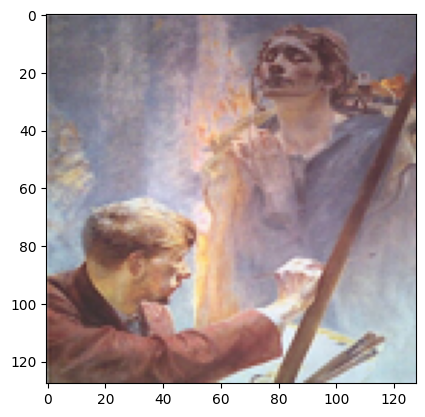

In [14]:
plt.imshow(images_np[50])

# Define X and Y

In [15]:
X =  np.array(images_np, dtype='float32') / 255.0

In [16]:
y = df['style']

# Train/test split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,      
    random_state=42,
    stratify=y
)

In [18]:
### Normalizing pixels' intensities
X_train = X_train / 255.
X_test = X_test / 255.

In [19]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

In [20]:
### Encoding the labels
y_train_cat = to_categorical(y_train_encoded, 10).astype('float32')
y_test_cat = to_categorical(y_test_encoded, 10).astype('float32')

# Initialize a model

In [21]:
def initialize_model_large():
    '''instanciate and return the CNN architecture of your choice with less than 150,000 params'''
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(16, kernel_size=(4, 4),padding='same' , activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Third Convolution & MaxPooling
    model.add(layers.Conv2D(64, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Fourth Convolution & MaxPooling
    model.add(layers.Conv2D(128, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [22]:
def initialize_model_small():
    '''instanciate and return the CNN architecture of your choice with less than 150,000 params'''
    model = Sequential()
    model.add(Input(shape=(128, 128, 3)))

    ### First Convolution & MaxPooling
    model.add(layers.Conv2D(16, kernel_size=(4, 4),padding='same' , activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))

    ### Second Convolution & MaxPooling
    model.add(layers.Conv2D(32, kernel_size=(3, 3),padding='same', activation='relu'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    
    ### Flattening
    model.add(layers.Flatten())

    ### One Fully Connected layer - "Fully Connected" is equivalent to saying "Dense"
    model.add(layers.Dense(10, activation='relu'))

    ### Last layer - Classification Layer with 10 outputs corresponding to 10 digits
    model.add(layers.Dense(10, activation='softmax'))

    return model

In [23]:
def compile_model(model):
    '''return a compiled model suited for the CIFAR-10 task'''
    model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return model

In [24]:
model_small = compile_model(initialize_model_small())

2025-09-02 16:10:59.201314: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [25]:
model_small.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 16)   │           784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 10)             │       327,690 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           110 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,224 (1.27 MB)

 Trainable params: 333,224 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

# Train the model

In [26]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [27]:
history_small = model_small.fit(X_train, y_train_cat, epochs=3, validation_split = 0.2, batch_size=8)

Epoch 1/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step - accuracy: 0.1786 - loss: 2.2682 - val_accuracy: 0.1071 - val_loss: 2.2907
Epoch 2/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.1429 - loss: 2.1708 - val_accuracy: 0.1786 - val_loss: 2.4401
Epoch 3/3
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 124ms/step - accuracy: 0.1786 - loss: 2.0882 - val_accuracy: 0.0714 - val_loss: 2.3486


(<Axes: title={'center': 'loss'}>, <Axes: title={'center': 'Accuracy'}>)

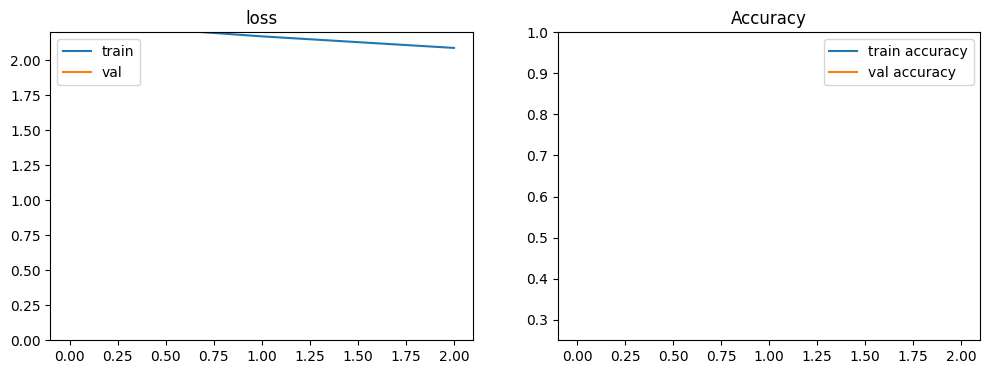

In [28]:
plot_history(history_small)